In [1]:
import os
import time
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime
from model_settings import ms
from df_collector import df_collector
pd.set_option("display.max_columns",None)
pd.options.display.float_format = '{:.5f}'.format
root = Path().resolve().parent.parent
df_collector.root = root
models_dir = os.path.join(root,ms.trained_models)
train_start = time.time()
train_start_datetime = datetime.fromtimestamp(train_start)
train_start_tag = train_start_datetime.strftime('%c')
print("\n"+"#"*18+"\n# training start #\n"+
      "#"*18+"\n"+f"\n{train_start_tag}")


##################
# training start #
##################

Fri Nov  8 13:58:20 2024


In [2]:
data = df_collector.cboe_spx_barriers().iloc[:,1:]
pricename = [f for f in data.columns if f.find('_price')!=-1 and f.find('spot_')==-1 and f.find('strike_')==-1][0]
filetag = f'cboe spx {pricename[:pricename.find('_',0)]}'
og_count = data.shape[0]
print(f'collected {pricename[:pricename.find('_',0)]} options')
data

collected barrier options


,spot_price,strike_price,barrier,days_to_maturity,updown,outin,w,barrier_type_name,rebate,dividend_rate,risk_free_rate,theta,kappa,rho,eta,v0,calculation_date,date,barrier_price
0,3716.00000,3344.40000,1858.00000,60,Down,Out,call,DownOut,0.00000,0.01586,0.00061,0.38656,1.60369,-0.78917,2.59536,0.00950,2021-01-05 11:36:23.909,2021-01-05,401.09011
1,3716.00000,3344.40000,1858.00000,60,Down,Out,put,DownOut,0.00000,0.01586,0.00061,0.38656,1.60369,-0.78917,2.59536,0.00950,2021-01-05 11:36:23.909,2021-01-05,31.89254
2,3716.00000,3344.40000,1858.00000,60,Down,In,call,DownIn,0.00000,0.01586,0.00061,0.38656,1.60369,-0.78917,2.59536,0.00950,2021-01-05 11:36:23.909,2021-01-05,0.22324
3,3716.00000,3344.40000,1858.00000,60,Down,In,put,DownIn,0.00000,0.01586,0.00061,0.38656,1.60369,-0.78917,2.59536,0.00950,2021-01-05 11:36:23.909,2021-01-05,6.92539
4,3716.00000,3344.40000,1858.00000,90,Down,Out,call,DownOut,0.00000,0.01586,0.00061,0.38656,1.60369,-0.78917,2.59536,0.00950,2021-01-05 11:36:23.909,2021-01-05,427.25251
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1153435,5857.00000,6442.70000,8785.50000,540,Up,In,put,UpIn,0.00000,0.01269,0.04181,0.00000,4.06705,-0.71781,1.48700,0.12159,2024-10-14 15:26:27.717,2024-10-14,20.71847
1153436,5857.00000,6442.70000,8785.50000,720,Up,Out,call,UpOut,0.00000,0.01269,0.04181,0.00000,4.06705,-0.71781,1.48700,0.12159,2024-10-14 15:26:27.717,2024-10-14,107.86907
1153437,5857.00000,6442.70000,8785.50000,720,Up,Out,put,UpOut,0.00000,0.01269,0.04181,0.00000,4.06705,-0.71781,1.48700,0.12159,2024-10-14 15:26:27.717,2024-10-14,293.41320
1153438,5857.00000,6442.70000,8785.50000,720,Up,In,call,UpIn,0.00000,0.01269,0.04181,0.00000,4.06705,-0.71781,1.48700,0.12159,2024-10-14 15:26:27.717,2024-10-14,0.00000


In [3]:
pd.Series(np.random.normal(scale=0.002,size=10000)).describe()

count   10000.00000
mean        0.00002
std         0.00201
min        -0.00721
25%        -0.00131
50%         0.00003
75%         0.00135
max         0.00736
dtype: float64

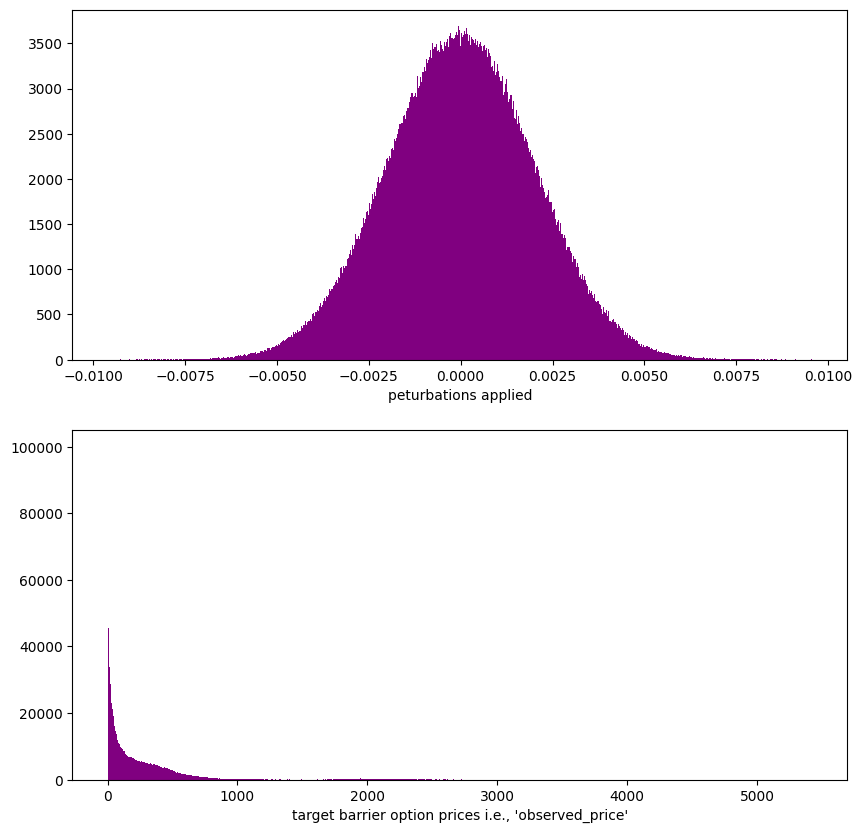

total data count: 892546
count   892546.00000
mean       239.20597
std        366.41735
min          0.36552
25%         26.73478
50%        117.79499
75%        324.56762
max       5424.82712
Name: observed_price, dtype: float64


In [4]:
data = data[data[pricename]<=data['spot_price']]
data = data[data[pricename]>=0.01].copy()
data['observed_price'] = data[pricename]+np.random.normal(scale=0.002,size=data.shape[0])
data = data[data['observed_price']>=data['spot_price']*0.0001].copy()
p = data[pricename]-data['observed_price']
plotprices = data['observed_price']

fig,axs = plt.subplots(2,figsize=(10,10))
axs[0].hist(p,bins=int(len(p)**0.5),color='purple')
axs[0].set_xlabel('peturbations applied')
axs[1].hist(plotprices,bins=int(len(plotprices)**0.5),color='purple')
axs[1].set_xlabel(f"target {pricename[:pricename.find('_')]} option prices i.e., 'observed_price'")
plt.show()
print(f"total data count: {data.shape[0]}")
print(data['observed_price'].describe())

# training procedure

In [5]:
from convsklearn import convsklearn
trainer = convsklearn()
help(trainer)
print('instance variables:')
trainer.__dict__

Help on convsklearn in module convsklearn.convsklearn object:

class convsklearn(builtins.object)
 |  convsklearn(target_name='observed_price', excluded_features=['barrier_price', 'asian', 'observed_price', 'outin', 'updown', 'n_fixings'])
 |
 |  a proprietary class of convenience wrappers for sklearn
 |
 |  Methods defined here:
 |
 |  __init__(self, target_name='observed_price', excluded_features=['barrier_price', 'asian', 'observed_price', 'outin', 'updown', 'n_fixings'])
 |      Initialize self.  See help(type(self)) for accurate signature.
 |
 |  load_data(self, data)
 |
 |  preprocess_data(self, development_dates, test_dates, plot=True)
 |
 |  run_dnn(self, print_details=True)
 |
 |  test_prediction_accuracy(self)
 |
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |
 |  __dict__
 |      dictionary for instance variables
 |
 |  __weakref__
 |      list of weak references to the object

instance variables:


{'raw_data': Empty DataFrame
 Columns: []
 Index: [],
 'dataset': Empty DataFrame
 Columns: []
 Index: [],
 'target_name': 'observed_price',
 'excluded_features': ['barrier_price',
  'asian',
  'observed_price',
  'outin',
  'updown',
  'n_fixings'],
 'numerical_features': [],
 'categorical_features': [],
 'feature_set': [],
 'n_features': 0,
 'development_dates': {},
 'test_dates': {},
 'train_data': {},
 'test_data': {},
 'train_X': {},
 'train_y': {},
 'test_X': {},
 'test_y': {},
 'preprocessor': None,
 'pipeline': None,
 'model': None,
 'model_fit': None,
 'dnn_runtime': 0,
 'numerical_scaler': StandardScaler()}

In [6]:
trainer.raw_data

""


In [7]:
trainer.load_data(data)
trainer.__dict__
trainer.dataset

,spot_price,strike_price,barrier,days_to_maturity,updown,outin,w,barrier_type_name,rebate,dividend_rate,risk_free_rate,theta,kappa,rho,eta,v0,calculation_date,date,barrier_price,observed_price
0,3716.00000,3344.40000,1858.00000,60,Down,Out,call,DownOut,0.00000,0.01586,0.00061,0.38656,1.60369,-0.78917,2.59536,0.00950,2021-01-05 11:36:23.909,2021-01-05,401.09011,401.09000
1,3716.00000,3344.40000,1858.00000,60,Down,Out,put,DownOut,0.00000,0.01586,0.00061,0.38656,1.60369,-0.78917,2.59536,0.00950,2021-01-05 11:36:23.909,2021-01-05,31.89254,31.88927
3,3716.00000,3344.40000,1858.00000,60,Down,In,put,DownIn,0.00000,0.01586,0.00061,0.38656,1.60369,-0.78917,2.59536,0.00950,2021-01-05 11:36:23.909,2021-01-05,6.92539,6.92210
4,3716.00000,3344.40000,1858.00000,90,Down,Out,call,DownOut,0.00000,0.01586,0.00061,0.38656,1.60369,-0.78917,2.59536,0.00950,2021-01-05 11:36:23.909,2021-01-05,427.25251,427.25402
5,3716.00000,3344.40000,1858.00000,90,Down,Out,put,DownOut,0.00000,0.01586,0.00061,0.38656,1.60369,-0.78917,2.59536,0.00950,2021-01-05 11:36:23.909,2021-01-05,45.27742,45.27427
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1153434,5857.00000,6442.70000,8785.50000,540,Up,In,call,UpIn,0.00000,0.01269,0.04181,0.00000,4.06705,-0.71781,1.48700,0.12159,2024-10-14 15:26:27.717,2024-10-14,1.35501,1.35209
1153435,5857.00000,6442.70000,8785.50000,540,Up,In,put,UpIn,0.00000,0.01269,0.04181,0.00000,4.06705,-0.71781,1.48700,0.12159,2024-10-14 15:26:27.717,2024-10-14,20.71847,20.71946
1153436,5857.00000,6442.70000,8785.50000,720,Up,Out,call,UpOut,0.00000,0.01269,0.04181,0.00000,4.06705,-0.71781,1.48700,0.12159,2024-10-14 15:26:27.717,2024-10-14,107.86907,107.86945
1153437,5857.00000,6442.70000,8785.50000,720,Up,Out,put,UpOut,0.00000,0.01269,0.04181,0.00000,4.06705,-0.71781,1.48700,0.12159,2024-10-14 15:26:27.717,2024-10-14,293.41320,293.41617


## preprocessing

In [8]:
dates = pd.Series(np.sort(data['date'].unique()))
dates

0      2021-01-05
1      2021-01-11
2      2021-01-14
3      2021-01-15
4      2021-01-19
          ...    
395    2024-09-24
396    2024-10-07
397    2024-10-08
398    2024-10-09
399    2024-10-14
Length: 400, dtype: object

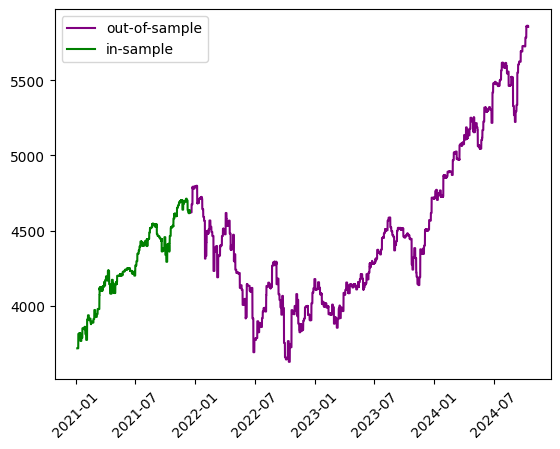

In [9]:
development_dates = dates[:len(dates)//4]
test_dates = dates[~dates.isin(development_dates)]
trainer.preprocess_data(development_dates,test_dates)

## training

In [10]:
trainer.run_dnn()


training on 227997 samples...

alpha: 0.01
hidden_layer_sizes: (14, 14)
learning_rate: adaptive
learning_rate_init: 0.1
solver: sgd
early_stopping: False
max_iter: 500
warm_start: True
tol: 0.0001
cpu: 31.784058809280396


In [11]:
print('instance varianbles:')
trainer.__dict__

instance varianbles:


{'raw_data':          spot_price  strike_price    barrier  days_to_maturity updown outin  \
 0        3716.00000    3344.40000 1858.00000                60   Down   Out   
 1        3716.00000    3344.40000 1858.00000                60   Down   Out   
 3        3716.00000    3344.40000 1858.00000                60   Down    In   
 4        3716.00000    3344.40000 1858.00000                90   Down   Out   
 5        3716.00000    3344.40000 1858.00000                90   Down   Out   
 ...             ...           ...        ...               ...    ...   ...   
 1153434  5857.00000    6442.70000 8785.50000               540     Up    In   
 1153435  5857.00000    6442.70000 8785.50000               540     Up    In   
 1153436  5857.00000    6442.70000 8785.50000               720     Up   Out   
 1153437  5857.00000    6442.70000 8785.50000               720     Up   Out   
 1153439  5857.00000    6442.70000 8785.50000               720     Up    In   
 
             w barrier_typ

In [12]:
trainer.model_fit

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      ColumnTransformer(transformers=[('StandardScaler',
                                                                                       StandardScaler(),
                                                                                       ['spot_price',
                                                                                        'strike_price',
                                                                                        'barrier',
                                                                                        'days_to_maturity',
                                                                                        'rebate',
                                                                                        'dividend_rate',
                                                                                        'risk_free_rate',
                                                                                        'theta',
                                                                                        'kappa',
                                                                                        'rho',
                                                                                        'eta',
                                                                                        'v0']),
                                                                                      ('OneHotEncoder',
                                                                                       OneHotEncoder(sparse_output=False),
                                                                                       ['w',
                                                                                        'barrier_type_name'])])),
                                                     ('regressor',
                                                      MLPRegressor(alpha=0.01,
                                                                   hidden_layer_sizes=(14,
                                                                                       14),
                                                                   learning_rate='adaptive',
                                                                   learning_rate_init=0.1,
                                                                   max_iter=500,
                                                                   solver='sgd',
                                                                   warm_start=True))]),
                           transformer=StandardScaler())

### initial test

In [13]:
train_test = trainer.test_prediction_accuracy()


in sample:
     RMSE: 53.77564320223443
     MAE: 33.055490093509725

out of sample:
     RMSE: 30425.44889432017
     MAE: 25342.24121466138


## saving

In [14]:
train_end = time.time()
train_end_tag = str(datetime.fromtimestamp(
    train_end).strftime("%Y_%m_%d %H%M%S%f"))
file_tag = str(train_end_tag + " " + filetag)
files_dir = os.path.join(models_dir,file_tag)

def save_model():
    if Path(files_dir).exists():
        pass
    else:
        os.mkdir(files_dir)
    file_dir = os.path.join(files_dir,file_tag)
    joblib.dump(trainer.__dict__,str(f"{file_dir}.pkl"))
    pd.set_option("display.max_columns",None)
    print(f"model saved to {file_dir}")

print(f"execute the command 'save_model()' to save the following model: {file_tag}")
train_runtime = train_end-train_start
print(f"\ncpu: {train_runtime}")

execute the command 'save_model()' to save the following model: 2024_11_08 135856485705 cboe spx barrier

cpu: 36.261804819107056


In [15]:
help(trainer)

Help on convsklearn in module convsklearn.convsklearn object:

class convsklearn(builtins.object)
 |  convsklearn(target_name='observed_price', excluded_features=['barrier_price', 'asian', 'observed_price', 'outin', 'updown', 'n_fixings'])
 |
 |  a proprietary class of convenience wrappers for sklearn
 |
 |  Methods defined here:
 |
 |  __init__(self, target_name='observed_price', excluded_features=['barrier_price', 'asian', 'observed_price', 'outin', 'updown', 'n_fixings'])
 |      Initialize self.  See help(type(self)) for accurate signature.
 |
 |  load_data(self, data)
 |
 |  preprocess_data(self, development_dates, test_dates, plot=True)
 |
 |  run_dnn(self, print_details=True)
 |
 |  test_prediction_accuracy(self)
 |
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |
 |  __dict__
 |      dictionary for instance variables
 |
 |  __weakref__
 |      list of weak references to the object

